<span style="color: #E45D00; font-family: Segoe UI; font-size: 1.9em; font-weight: 300;">📐 Setup MMDetection</span>

In [1]:
# !pip install mmsegmentation

In [2]:
%%bash
# Check nvcc version
nvcc -V
echo
# Check GCC version
gcc --version
echo
# Check the version of torch and cuda packages
pip list | grep "torch\|cuda"

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2021 NVIDIA Corporation
Built on Mon_May__3_19:15:13_PDT_2021
Cuda compilation tools, release 11.3, V11.3.109
Build cuda_11.3.r11.3/compiler.29920130_0

gcc (Ubuntu 7.5.0-3ubuntu1~18.04) 7.5.0
Copyright (C) 2017 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.


torch                       1.11.0
torchelastic                0.2.2
torchtext                   0.12.0
torchvision                 0.12.0


In [3]:
# # Install PyTorch
# !conda install pytorch=1.10.0 torchvision cudatoolkit=11.1 -c pytorch
# # Install MMCV
# !pip install mmcv-full -f https://download.openmmlab.com/mmcv/dist/cu111/torch1.10/index.html
# !mim install mmdet

In [4]:
import os
# !rm -rf mmsegmentation
# !git clone https://github.com/open-mmlab/mmsegmentation.git 
# %cd mmsegmentation
# !pip install -e .
# os.chdir("/home/xuchen/Desktop/openmmlab/mmseg_training_segmetation/mmsegmentation/checkpoints/0_mmseg/mmseg_training_segmetation")

<span style="color: #E45D00; font-family: Segoe UI; font-size: 1.9em; font-weight: 300;">🔨 Setup Weights & Biases</span>

In [5]:
# %%capture
# !pip install wandb --upgrade

In [6]:
import wandb
wandb.login()

wandb: Currently logged in as: xuchenweights. Use `wandb login --relogin` to force relogin


True

<span style="color: #E45D00; font-family: Segoe UI; font-size: 1.9em; font-weight: 300;">🔨 system info</span>

In [7]:
import sys
print(f"use python version and path: {os.path.abspath(sys.executable)}")
print("jupyter-lab path 系统搜索路径:{}".format(sys.path[0]))
print(f"当前工作目录 文件读写等相关操作使用的基本路径。{os.getcwd()}")

use python version and path: /opt/conda/bin/python
jupyter-lab path 系统搜索路径:/mmsegmentation/xuchen_folder
当前工作目录 文件读写等相关操作使用的基本路径。/mmsegmentation/xuchen_folder


<span style="color: #E45D00; font-family: Segoe UI; font-size: 1.9em; font-weight: 300;">🔨 Imports and Seed Everything</span>

In [8]:
import torch, torchvision
print(f"torch version: {torch.__version__}")
print(f"torch cuda is_available: {torch.cuda.is_available()}")

# Check mmcv installation
from mmcv.ops import get_compiling_cuda_version, get_compiler_version
print(f"get_compiling_cuda_version: {get_compiling_cuda_version()}")
print(f"get_compiler_version: {get_compiler_version()}")
import mmcv
# Imports
import mmseg
print(f"mmseg version is :{mmseg.__version__}")


from mmseg.models import build_segmentor



import numpy as np
from pathlib import Path
import json
from pycocotools.coco import COCO
from PIL import Image
from matplotlib import pyplot as plt
import cv2
import os.path as osp 

torch version: 1.11.0
torch cuda is_available: True
get_compiling_cuda_version: 11.3
get_compiler_version: GCC 9.3
mmseg version is :1.0.0


In [9]:
# from mmseg.datasets import build_dataset
# from mmseg.apis import train_segmentor
# from mmseg.apis import inference_segmentor

In [10]:
import random
from mmengine.runner import set_random_seed
seed = 1234
data_folder_name ="powertain_goods_data"
"""Sets the random seeds."""
set_random_seed(seed, deterministic=False)
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
#torch.backends.cudnn.deterministic 确定性的
#是啥？确定性的，顾名思义，将这个 flag 置为True的话，每次返回的卷积算法将是确定的，即默认算法。如果配合上设置 Torch 的随机种子为固定值的话，
#应该可以保证每次运行网络的时候相同输入的输出是固定的，代码大致这样
torch.backends.cudnn.deterministic = True
#设置 torch.backends.cudnn.benchmark=True 将会让程序在开始时花费一点额外时间，为整个网络的每个卷积层搜索最适合它的卷积实现算法，
#进而实现网络的加速。适用场景是网络结构固定（不是动态变化的），网络的输入形状（包括 batch size，图片大小，输入的通道）是不变的，
#其实也就是一般情况下都比较适用。反之，如果卷积层的设置一直变化，将会导致程序不停地做优化，反而会耗费更多的时间。
torch.backends.cudnn.benchmark = False
os.environ['PYTHONHASHSEED'] = str(seed)

You can change the test_n to get a different split

<span style="color: #E45D00; font-family: Segoe UI; font-size: 1.9em; font-weight: 300;">🔨 Convert the coco dataset to Mask image labels and resize images size</span>

In [11]:
if_create_trian_data = True
image_palette = [[0, 0, 0], [128, 0, 0], [0, 128, 0], [128, 128, 0], [0, 0, 128], [128, 0, 128],
                 [0, 128, 128], [128, 128, 128], [64, 0, 0], [192, 0, 0], [64, 128, 0], [192, 128, 0]]
coco_labels_path = data_folder_name +"/goods_labels.json"
Origin_images_dir = data_folder_name +"/Origin_images"
target_dim = 1024
if if_create_trian_data:
    Convert_the_coco_dataset_to_Mask_RGB_image_labels = True
    mmseg_labels_set_path = data_folder_name +"/labels_images"
    mmseg_resize_images_path = data_folder_name + "/resize_images"
    coco_labels_path = coco_labels_path
    target_dims = (target_dim,target_dim)

    if_resize_image = True

    if Convert_the_coco_dataset_to_Mask_RGB_image_labels:
         if os.path.isdir(mmseg_labels_set_path)==False:
            os.makedirs(mmseg_labels_set_path)
            os.makedirs(mmseg_resize_images_path)


            coco = COCO(coco_labels_path)
            how_much_file = os.listdir(Origin_images_dir)
            how_much_sample =len([fn for fn in how_much_file if fn.endswith("png")])
            print(f"how_much_sample:{how_much_sample}")
            cat_ids = coco.getCatIds()
            for sample_num in range(1,how_much_sample+1,1):
                all_mask_images=[]
                print(f"sample_num:{sample_num}")

                img = coco.imgs[sample_num]
                image_path = os.path.join(Origin_images_dir, img['file_name'])
                if if_resize_image:
                    image = cv2.imread(image_path)
                    resized_image = mmcv.imrescale(image,target_dims)
                 
                    mmseg_resize_images = mmseg_resize_images_path + "/"+ img['file_name']
                    cv2.imwrite(mmseg_resize_images,resized_image)
                image = np.array(Image.open(mmseg_resize_images_path+ "/"+ img['file_name']))
       
                for cat_id in cat_ids:
                    #print(f"cat ids:{cat_id}")
                    anns_ids = coco.getAnnIds(imgIds=img['id'], catIds=cat_id, iscrowd=None)
                    if anns_ids!=[]:
                        #print(f"anns_ids:{anns_ids}")
                        anns = coco.loadAnns(anns_ids)

                        mask = coco.annToMask(anns[0])*cat_id

                        for i in range(len(anns)):

                            mask = coco.annToMask(anns[i])*cat_id
                            all_mask_images.append(mask)

                mask_images = np.zeros((mask.shape), dtype=np.uint8)
                for i in range(len(all_mask_images)):
                    mask_images[mask_images==0] += all_mask_images[i][mask_images==0]
                    


                seg_img = Image.fromarray(mask_images).resize((resized_image.shape[1],resized_image.shape[0]))
                # print(seg_img)
                
                seg_img = seg_img.convert('P')
                seg_img.putpalette(np.array(image_palette, dtype=np.uint8))
                seg_img.save(osp.join(mmseg_labels_set_path +"/"+img['file_name'][0:-3]+"png"))


img size is(857, 1024, 3)


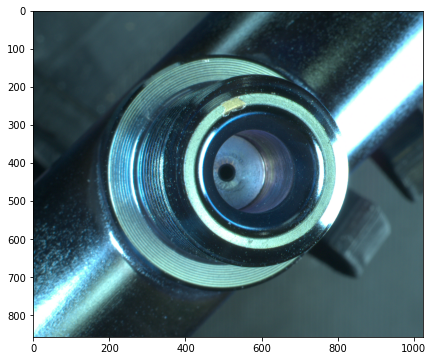

In [12]:
# Let's take a look at the dataset
import matplotlib.pyplot as plt
import os
import random
img_dir = "resize_images"
image_folder = data_folder_name + "/" + img_dir + "/"

# Get a list of all files in the image folder
all_images = os.listdir(image_folder)

# Select a random image file
random_image_file = random.choice(all_images)

# Read the image
img = mmcv.imread(image_folder + random_image_file)
print(f"img size is{img.shape}")
plt.figure(figsize=(8, 6))
plt.imshow(mmcv.bgr2rgb(img))
plt.show()

<span style="color: #E45D00; font-family: Segoe UI; font-size: 1.9em; font-weight: 300;">🔨 show label images data</span>

img size is(857, 1024, 3)


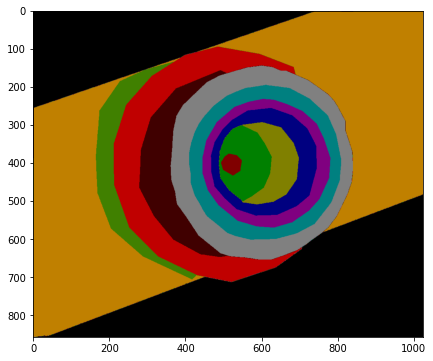

In [13]:
# Let's take a look at the dataset
import matplotlib.pyplot as plt
import os
import random
ann_dir = "labels_images"
image_folder = data_folder_name + "/"+ ann_dir + "/"

# Get a list of all files in the image folder
all_images = os.listdir(image_folder)

# Select a random image file
random_image_file = random.choice(all_images)

# Read the image
img = mmcv.imread(image_folder + random_image_file)
print(f"img size is{img.shape}")
plt.figure(figsize=(8, 6))
plt.imshow(mmcv.bgr2rgb(img))
plt.show()

<span style="color: #E45D00; font-family: Segoe UI; font-size: 1.9em; font-weight: 300;">🔨 splits</span>

In [14]:
# split train/val set randomly
import os
import mmengine
if if_create_trian_data:
    split_dir = data_folder_name + '/splits'
    if os.path.isdir(split_dir)==False:

        mmengine.mkdir_or_exist(osp.join(split_dir))
        filename_list = [osp.splitext(filename)[0] for filename in mmengine.scandir(
            osp.join( mmseg_labels_set_path), suffix='.png')]
        with open(osp.join( split_dir, 'train.txt'), 'w') as f:
          # select first 4/5 as train set
          train_length = int(len(filename_list)*9/10)
          f.writelines(line + '\n' for line in filename_list[:train_length])
        with open(osp.join( split_dir, 'val.txt'), 'w') as f:
          # select last 1/5 as train set
          f.writelines(line + '\n' for line in filename_list[train_length:])

<span style="color: #E45D00; font-family: Segoe UI; font-size: 1.9em; font-weight: 300;">🔨 download model and default config</span>

In [15]:
# !mim download mmsegmentation --config mask2former_swin-s_8xb2-160k_ade20k-512x512  --dest .

<span style="color: #E45D00; font-family: Segoe UI; font-size: 1.9em; font-weight: 300;">🔨 Setting base default setting</span>

In [16]:
from mmengine import Config
baseline_cfg_path = '/mmsegmentation/configs/mask2former/mask2former_swin-s_8xb2-160k_xuchen-512x512.py'
# /mmsegmentation/configs/mask2former/mask2former_swin-s_8xb2-160k_xuchen-512x512.py
cfg = Config.fromfile(baseline_cfg_path)
model_name = baseline_cfg_path.split("/")[-1].split(".")[0]
print(f"config base model of :{model_name} ")

config base model of :mask2former_swin-s_8xb2-160k_xuchen-512x512 


In [17]:
# cfg.norm_cfg = dict(type='BN', requires_grad=True)
# cfg.model.backbone.norm_cfg = cfg.norm_cfg


cfg.num_classes = 150
cfg.model.decode_head.num_classes = 150
cfg.train_dataloader.dataset.data_prefix = dict(img_path=img_dir, seg_map_path=ann_dir)
cfg.train_dataloader.dataset.ann_file = 'splits/train.txt'

cfg.val_dataloader.dataset.data_prefix = dict(img_path=img_dir, seg_map_path=ann_dir)
cfg.val_dataloader.dataset.ann_file = 'splits/val.txt'

# Set up working dir to save files and logs.
cfg.work_dir = 'work_dirs/xuchen_mask_segmetation'
cfg.data_root = data_folder_name


cfg.train_dataloader.num_workers= 4
cfg.train_dataloader.batch_size = 2
cfg.val_dataloader.num_workers = 4
cfg.test_dataloader.num_workers = 4

# cfg.train_dataloader = cfg.data_root
# cfg.val_dataloader = cfg.data_root

# print(f'Config:\n{cfg.pretty_text}')

<span style="color: #E45D00; font-family: Segoe UI; font-size: 1.9em; font-weight: 300;">🔨 Setting if train and log config</span>

In [18]:
# Change the wandb username and project name below
# wnb_username = 'xuchenweights'
# wnb_project_name = model_name

# import time 
# s = time.time()
# s=time.gmtime(s)
# str_time =time.strftime("%Y-%m-%d_%H-%M-%S", s)
# #TextLoggerHook is default ，so set WandbLoggerHook
# cfg.default_hooks = [dict(type='TextLoggerHook'),
#                         dict(type='WandbLoggerHook',
#                              init_kwargs=dict(project=wnb_project_name,
#                                               name=f'exp-{model_name}-{data_folder_name}-{str_time}',
#                                               entity=wnb_username))
#                        ]

<span style="color: #E45D00; font-family: Segoe UI; font-size: 1.9em; font-weight: 300;">🚀 Build Dataset and Start Training</span>

In [19]:
if_train = False

In [20]:
from mmengine.runner import Runner
if if_train:
    runner = Runner.from_cfg(cfg)

06/02 00:28:54 - mmengine - INFO - 
------------------------------------------------------------
System environment:
    sys.platform: linux
    Python: 3.8.12 (default, Oct 12 2021, 13:49:34) [GCC 7.5.0]
    CUDA available: True
    numpy_random_seed: 822569775
    GPU 0: NVIDIA GeForce RTX 3070 Ti
    CUDA_HOME: /usr/local/cuda
    NVCC: Cuda compilation tools, release 11.3, V11.3.109
    GCC: gcc (Ubuntu 7.5.0-3ubuntu1~18.04) 7.5.0
    PyTorch: 1.11.0
    PyTorch compiling details: PyTorch built with:
  - GCC 7.3
  - C++ Version: 201402
  - Intel(R) oneAPI Math Kernel Library Version 2021.4-Product Build 20210904 for Intel(R) 64 architecture applications
  - Intel(R) MKL-DNN v2.5.2 (Git Hash a9302535553c73243c632ad3c4c80beec3d19a1e)
  - OpenMP 201511 (a.k.a. OpenMP 4.5)
  - LAPACK is enabled (usually provided by MKL)
  - NNPACK is enabled
  - CPU capability usage: AVX2
  - CUDA Runtime 11.3
  - NVCC architecture flags: -gencode;arch=compute_37,code=sm_37;-gencode;arch=compute_50,cod

/mmsegmentation/mmseg/engine/hooks/visualization_hook.py:61: UserWarning: The draw is False, it means that the hook for visualization will not take effect. The results will NOT be visualized or stored.
  warnings.warn('The draw is False, it means that the '


In [21]:
# start training
if if_train:
 runner.train()

06/02 00:29:00 - mmengine - INFO - paramwise_options -- backbone.patch_embed.projection.weight:lr=1e-05
06/02 00:29:00 - mmengine - INFO - paramwise_options -- backbone.patch_embed.projection.weight:weight_decay=0.05
06/02 00:29:00 - mmengine - INFO - paramwise_options -- backbone.patch_embed.projection.weight:lr_mult=0.1
06/02 00:29:00 - mmengine - INFO - paramwise_options -- backbone.patch_embed.projection.weight:decay_mult=1.0
06/02 00:29:00 - mmengine - INFO - paramwise_options -- backbone.patch_embed.projection.bias:lr=1e-05
06/02 00:29:00 - mmengine - INFO - paramwise_options -- backbone.patch_embed.projection.bias:weight_decay=0.05
06/02 00:29:00 - mmengine - INFO - paramwise_options -- backbone.patch_embed.projection.bias:lr_mult=0.1
06/02 00:29:00 - mmengine - INFO - paramwise_options -- backbone.patch_embed.projection.bias:decay_mult=1.0
06/02 00:29:00 - mmengine - INFO - paramwise_options -- backbone.patch_embed.norm.weight:lr=1e-05
06/02 00:29:00 - mmengine - INFO - paramwi

/opt/conda/lib/python3.8/site-packages/mmdet/models/layers/positional_encoding.py:84: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  dim_t = self.temperature**(2 * (dim_t // 2) / self.num_feats)
/opt/conda/lib/python3.8/site-packages/torch/functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755903507/work/aten/src/ATen/native/TensorShape.cpp:2228.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


KeyboardInterrupt: 

<span style="color: #E45D00; font-family: Segoe UI; font-size: 1.9em; font-weight: 300;">📰 Inference and Visualize Output</span>

In [4]:
data_folder_name ="powertain_goods_data"
from mmengine import Config
baseline_cfg_path = '/mmsegmentation/xuchen_folder/work_dirs/xuchen_mask_segmetation/mask2former_swin-s_8xb2-160k_xuchen-512x512.py'
# /mmsegmentation/configs/mask2former/mask2former_swin-s_8xb2-160k_xuchen-512x512.py
cfg = Config.fromfile(baseline_cfg_path)
model_name = baseline_cfg_path.split("/")[-1].split(".")[0]
print(f"config base model of :{model_name} ")

config base model of :mask2former_swin-s_8xb2-160k_xuchen-512x512 


In [5]:
from mmseg.apis import init_model, inference_model, show_result_pyplot
# Init the model from the config and the checkpoint
checkpoint_path = cfg.work_dir +'/best_mIoU_iter_110000.pth'
model = init_model(cfg, checkpoint_path, 'cuda:0')

Loads checkpoint by local backend from path: work_dirs/xuchen_mask_segmetation/best_mIoU_iter_110000.pth


In [11]:
# while(True):
import os
data_address = data_folder_name +"/test_images"
how_much_file = os.listdir(data_address)
filtered_list = list(filter(lambda how_much_file: how_much_file.endswith(".png"), how_much_file))
# model.cfg=cfg
print(f"test_image_address:{data_address}")
print(f"how_much_file:{len(filtered_list)}")
print(f"image_list:{filtered_list} ")

test_image_address:powertain_goods_data/test_images
how_much_file:146
image_list:['50_3.png', '4_1.png', '52_2.png', '21_3.png', '6_1.png', '32_2.png', '58_2.png', '20_1.png', '16_1.png', '37_2.png', '12_1.png', '28_1.png', '3_2.png', '16_2.png', '57_2.png', '17_1.png', '27_3.png', '44_2.png', '7_2.png', '58_1.png', '26_2.png', '96_1.png', '41_2.png', '16_3.png', '56_1.png', '10_1.png', '63_1.png', '5_2.png', '39_2.png', '60_1.png', '51_2.png', '35_1.png', '25_2.png', '32_3.png', '64_2.png', '44_1.png', '98_3.png', '60_2.png', '53_1.png', '91_2.png', '38_2.png', '26_3.png', '63_2.png', '61_2.png', '14_1.png', '36_1.png', '15_3.png', '47_1.png', '27_1.png', '48_3.png', '59_3.png', '34_2.png', '31_3.png', '21_1.png', '47_2.png', '28_2.png', '98_2.png', '50_1.png', '62_2.png', '18_1.png', '11_1.png', '41_1.png', '15_2.png', '97_1.png', '95_1.png', '32_1.png', '31_1.png', '1_2.png', '59_2.png', '15_1.png', '59_1.png', '11_2.png', '19_2.png', '33_1.png', '6_2.png', '26_1.png', '7_1.png', '1

origin_image_path:powertain_goods_data/test_images/50_3.png
img image size is:(428, 512, 3)
the data shape input model is!!!!!!:torch.Size([1, 3, 448, 512])
run time is :0.48444175720214844
save_resuit_dir:powertain_goods_data/result/50_3_result.png
06/02 00:37:42 - mmengine - WARNING - `Visualizer` backend is not initialized because save_dir is None.


/opt/conda/lib/python3.8/site-packages/mmdet/models/layers/positional_encoding.py:84: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  dim_t = self.temperature**(2 * (dim_t // 2) / self.num_feats)
/opt/conda/lib/python3.8/site-packages/torch/functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755903507/work/aten/src/ATen/native/TensorShape.cpp:2228.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


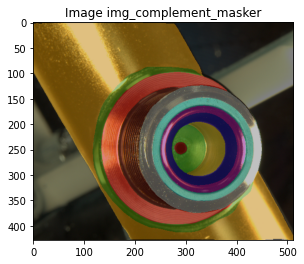

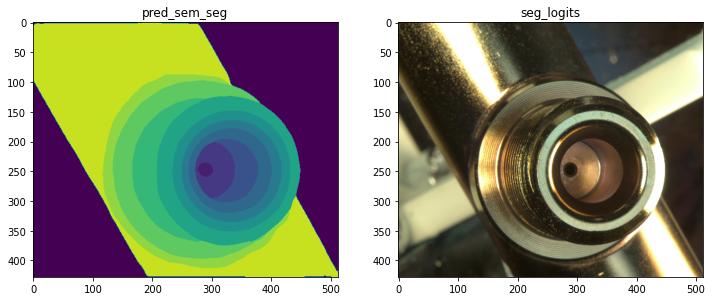

origin_image_path:powertain_goods_data/test_images/4_1.png
img image size is:(428, 512, 3)
the data shape input model is!!!!!!:torch.Size([1, 3, 448, 512])
run time is :0.05339860916137695
save_resuit_dir:powertain_goods_data/result/4_1_result.png


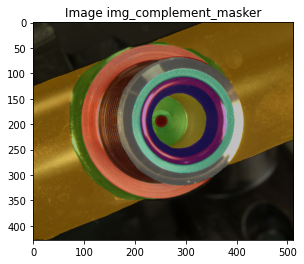

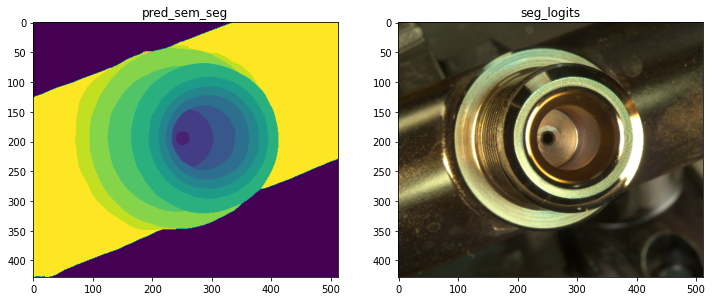

origin_image_path:powertain_goods_data/test_images/52_2.png
img image size is:(428, 512, 3)
the data shape input model is!!!!!!:torch.Size([1, 3, 448, 512])
run time is :0.051085710525512695
save_resuit_dir:powertain_goods_data/result/52_2_result.png


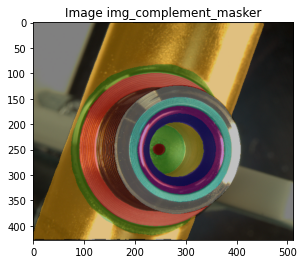

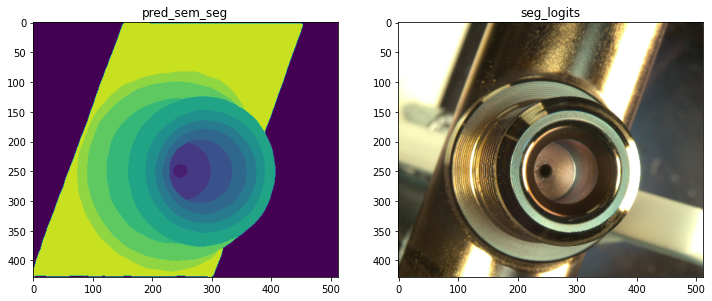

origin_image_path:powertain_goods_data/test_images/21_3.png
img image size is:(428, 512, 3)
the data shape input model is!!!!!!:torch.Size([1, 3, 448, 512])
run time is :0.05009055137634277
save_resuit_dir:powertain_goods_data/result/21_3_result.png


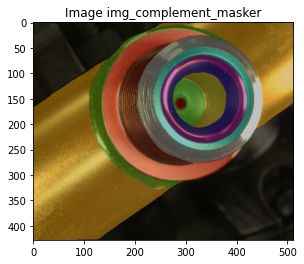

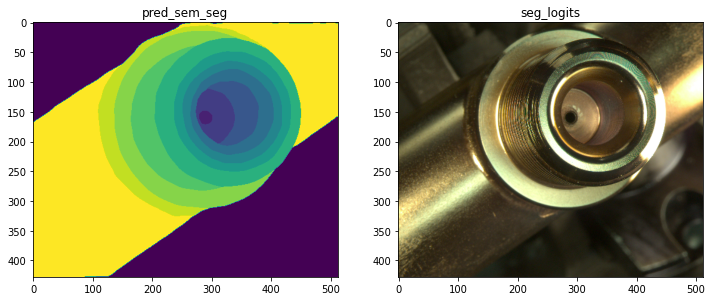

origin_image_path:powertain_goods_data/test_images/6_1.png
img image size is:(428, 512, 3)
the data shape input model is!!!!!!:torch.Size([1, 3, 448, 512])
run time is :0.049480438232421875
save_resuit_dir:powertain_goods_data/result/6_1_result.png


KeyboardInterrupt: 

In [13]:
import mmengine
mmengine.mkdir_or_exist(data_folder_name + "/result/")
mmengine.mkdir_or_exist(data_folder_name + "/splited_images_result/")

import time
import mmcv
import matplotlib.pyplot as plt

for i in range(len(filtered_list)):

    image_nn = data_folder_name + "/test_images/" + filtered_list[i][0:-4]
    img_path = image_nn + ".png"
    print(f"origin_image_path:{img_path}")
    img = mmcv.imread(img_path)
    resized_img = mmcv.imrescale(img,(512,512))
    print(f"img image size is:{resized_img.shape}")
    # save_resize = image_result_path + "_resize.png"
    # print(f"save_resize_dir:{save_resize}")


        
    start_time = time.time()
    result = inference_model(model, resized_img)
    # print(result)

    
    # Assuming seg_data is your input data
    seg_data = result
    
    # Extracting fields from the data
    pred_sem_seg_data = seg_data.pred_sem_seg.data.cpu().numpy().squeeze()
    
    end_time = time.time()
    print(f"run time is :{end_time-start_time}")

    image_result_path = data_folder_name + "/result/" + filtered_list[i][0:-4]
    save_resuit_dir = image_result_path + "_result.png"
    print(f"save_resuit_dir:{save_resuit_dir}")
    
    vis_result = show_result_pyplot(model, resized_img,result, draw_gt=False,out_file=save_resuit_dir)


    # Displaying the images
    plt.figure(figsize=(12, 6))
    
    # Displaying pred_sem_seg image
    plt.subplot(1, 2, 1)
    plt.imshow(pred_sem_seg_data)
    plt.title('pred_sem_seg')
    
    # Displaying seg_logits image
    plt.subplot(1, 2, 2)
    plt.imshow(resized_img)
    plt.title('seg_logits')

    plt.show()
    

In [ ]:
# import cv2
# for i in range(len(filtered_list)):
#     start_time= time.time()
#     image_nn = data_folder_name + "/test_images/" + filtered_list[i][0:-4]
#     img_path = image_nn + ".png"
#     print(f"img_path:{img_path}")

#     # print(f"origin_image_path:{img_path}")
#     img = mmcv.imread(img_path)
#     plt.imshow(img)
#     plt.show()
#     resized_img = mmcv.imrescale(img,(256,256))
#     result = inference_model(model, resized_img)
#     image_result_path = data_folder_name + "/result/" + filtered_list[i][0:-4]
#     save_dir = image_result_path + "_result.jpg"
#     print(f"save_dir:{save_dir}")
#     end_time = time.time()
#     # print(f"speed time : {end_time-start_time}")
#     cv2.imwrite(save_dir,vis_result)

In [ ]:
# import cv2
# for i in range(len(filtered_list)):
#     start_time= time.time()
#     image_nn = data_folder_name + "/test_images/" + filtered_list[i][0:-4]
#     img_path = image_nn + ".png"
    
#     print(f"origin_image_path:{img_path}")
#     img = mmcv.imread(img_path)
#     resized_img = mmcv.imrescale(img,(428,512))
#     result = inference_model(model, resized_img)
#     image_result_path = data_folder_name + "/result/" + filtered_list[i][0:-4]
#     save_dir = image_result_path + "_result.jpg"
#     print(f"save_dir:{save_dir}")
#     end_time = time.time()
#     print(f"speed time : {end_time-start_time}")


    # vis_result = show_result_pyplot(model, img, result)
    # cv2.imwrite(save_dir,vis_result)
    # break


    # plt.imshow(mmcv.bgr2rgb(vis_result))
    # for ii in range(12):
        
    #     mask = result_map == ii
    #     # print(mask)
    #     # print(type(mask))
    #     # print(mask.shape)
    #     # plt.imshow(mask)
    #     # plt.show()
    #     # print(mask.shape)
    #     # print(mask[...,None].shape)
    #     part_image = origin_image * mask[...,None]

    #     # plt.imshow(part_image)
    #     # plt.show()
    #     imfromarray = Image.fromarray(part_image) 
        
    #     splited_images_result_folder = data_folder_name + "/splited_images_result/" + str(ii) + "/"
    #     mmcv.mkdir_or_exist(splited_images_result_folder)

    #     image_splited_images_result_path = splited_images_result_folder + filtered_list[i][0:-4]  
    #     image_name_result_parts = image_splited_images_result_path + "_part_" + str(ii) + "_result.jpg"
    #     imfromarray.save(image_name_result_parts)

In [ ]:
# import cv2
# # for i in range(len(filtered_list)):
# i = 10
# start_time= time.time()
# image_nn = data_folder_name + "/test_images/" + filtered_list[i][0:-4]
# img_path = image_nn + ".png"

# print(f"origin_image_path:{img_path}")
# img = mmcv.imread(img_path)
# resized_img = mmcv.imrescale(img,(256,256))
# result = inference_model(model, img)
# image_result_path = data_folder_name + "/result/" + filtered_list[i][0:-4]
# save_dir = image_result_path + "_result.jpg"
# print(f"save_dir:{save_dir}")
# end_time = time.time()
# print(f"speed time : {end_time-start_time}")






    # vis_result = show_result_pyplot(model, img, result)
    # cv2.imwrite(save_dir,vis_result)
    # break


    # plt.imshow(mmcv.bgr2rgb(vis_result))
    # for ii in range(12):
        
    #     mask = result_map == ii
    #     # print(mask)
    #     # print(type(mask))
    #     # print(mask.shape)
    #     # plt.imshow(mask)
    #     # plt.show()
    #     # print(mask.shape)
    #     # print(mask[...,None].shape)
    #     part_image = origin_image * mask[...,None]

    #     # plt.imshow(part_image)
    #     # plt.show()
    #     imfromarray = Image.fromarray(part_image) 
        
    #     splited_images_result_folder = data_folder_name + "/splited_images_result/" + str(ii) + "/"
    #     mmcv.mkdir_or_exist(splited_images_result_folder)

    #     image_splited_images_result_path = splited_images_result_folder + filtered_list[i][0:-4]  
    #     image_name_result_parts = image_splited_images_result_path + "_part_" + str(ii) + "_result.jpg"
    #     imfromarray.save(image_name_result_parts)